In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt


In [26]:
df = pd.read_csv("amazon.csv")

# Thống kê mô tả

In [27]:

print("Kiểm tra dữ liệu ban đầu:")
print(df.info())
print("\nMẫu dữ liệu:")
print(df.head())

Kiểm tra dữ liệu ban đầu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non

# Sơ đồ trực quan hóa

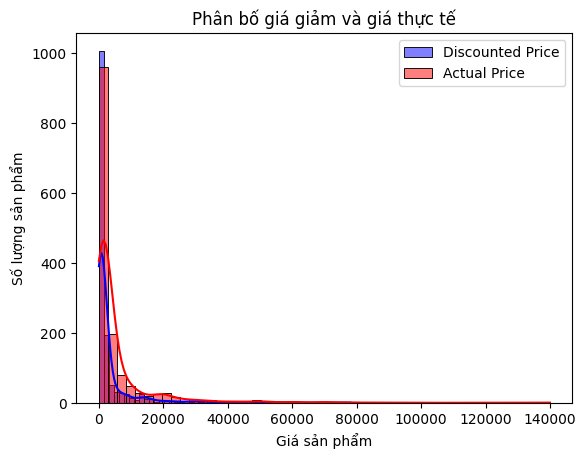

In [ ]:
sns.histplot(df['discounted_price'], bins=50, kde=True, color='blue', label='Discounted Price')
sns.histplot(df['actual_price'], bins=50, kde=True, color='red', label='Actual Price', alpha=0.5)

plt.xlabel("Giá sản phẩm")
plt.ylabel("Số lượng sản phẩm")
plt.title("Phân bố giá giảm và giá thực tế")
plt.legend()
plt.show()

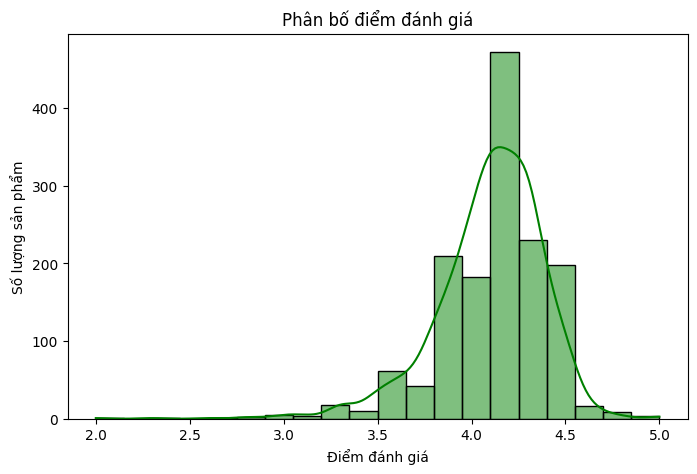

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], bins=20, kde=True, color='green')

plt.xlabel("Điểm đánh giá")
plt.ylabel("Số lượng sản phẩm")
plt.title("Phân bố điểm đánh giá")
plt.show()


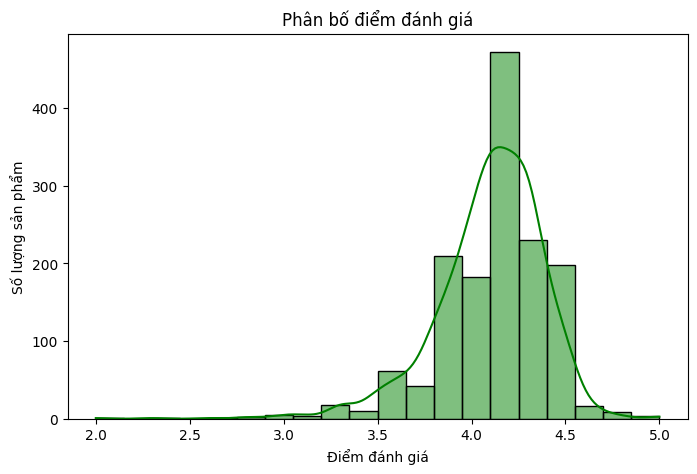

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], bins=20, kde=True, color='green')

plt.xlabel("Điểm đánh giá")
plt.ylabel("Số lượng sản phẩm")
plt.title("Phân bố điểm đánh giá")
plt.show()


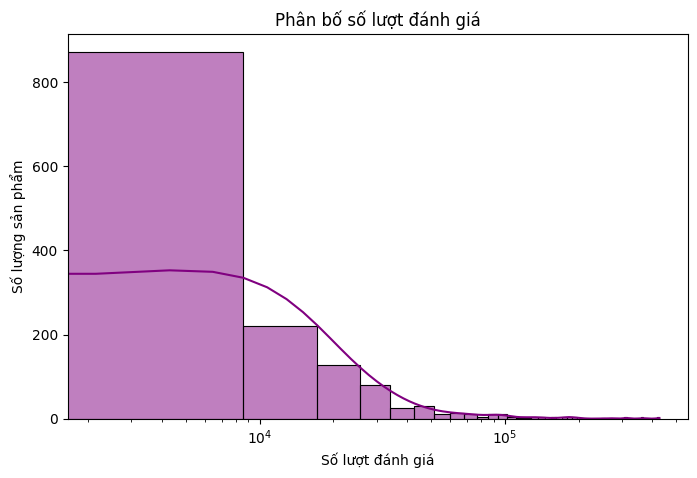

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['rating_count'], bins=50, kde=True, color='purple')

plt.xlabel("Số lượt đánh giá")
plt.ylabel("Số lượng sản phẩm")
plt.title("Phân bố số lượt đánh giá")
plt.xscale('log')  # Dùng log scale nếu dữ liệu phân bố không đều
plt.show()


# Xử lý dữ liệu

In [50]:
from sklearn.preprocessing import QuantileTransformer
# Xử lý từng nhóm cột
def clean_data(df):
    # Tạo bản sao để không ảnh hưởng đến dữ liệu gốc
    df_clean = df.copy()
    
    # Xử lý các cột ID
    id_columns = ['product_id', 'user_id', 'review_id']
    for col in id_columns:
        df_clean[col] = df_clean[col].astype(str)
    
    # Xử lý các cột text
    text_columns = ['product_name', 'category', 'about_product', 'user_name', 
                    'review_title', 'review_content', 'img_link', 'product_link']
    for col in text_columns:
        # Loại bỏ khoảng trắng thừa
        df_clean[col] = df_clean[col].str.strip()
        # Điền giá trị null bằng 'Unknown'
        df_clean[col] = df_clean[col].fillna('Unknown')
    #Xử lý các cột số
    numeric_columns = ['discounted_price', 'actual_price', 'discount_percentage', 
                      'rating', 'rating_count']
    for col in numeric_columns:
        # Chuyển đổi sang kiểu số
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        
    # Đảm bảo giá trị hợp lệ
    df_clean = df_clean[
    (df_clean["discounted_price"] >= 0) &  
    (df_clean["actual_price"] >= 0) &  
    (df_clean["discount_percentage"].between(0, 100)) &  
    (df_clean["rating"].between(0, 5)) &  
    (df_clean["rating_count"] >= 0)
]
    df_clean['rating'] = pd.to_numeric(df_clean['rating'], errors='coerce')
    return df_clean

# Mã hóa các cột phân loại
label_columns = ['category', 'product_name', 'user_name']
encoder = LabelEncoder()
for col in label_columns:
    df[col] = encoder.fit_transform(df[col])

#### Khởi tạo LabelEncoder và mã hóa từng cột
label_encoders = {}
for col in ["product_id", "user_id", "review_id", "category"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Lưu lại bộ mã hóa để dùng sau

#### Xử lý cột discounted_price và actual_price: loại bỏ ký tự ₹ và dấu phẩy
for col in ["discounted_price", "actual_price"]:
    df[col] = df[col].astype(str).str.replace(r"[₹,]", "", regex=True).astype(float)
df["discount_percentage"] = df["discount_percentage"].astype(str).str.replace("%", "").astype(float)

### Xử lý rating
# Đảm bảo giá trị rating nằm trong khoảng 1 - 5
df["rating"] = pd.to_numeric(df["rating"], errors="coerce").clip(1, 5)

### Xử lý rating_count
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution="normal")
df["rating_count"] = qt.fit_transform(df[["rating_count"]])
# Chuẩn hóa về khoảng 1 - 100
df["rating_count"] = rankdata(df["rating_count"], method="dense")
df["rating_count"] = df["rating_count"] + np.random.uniform(0, 0.5, size=len(df))  # Thêm nhiễu nhẹ để tránh trùng
df["rating_count"] = (df["rating_count"] * 10).round().astype(int)  # Nhân hệ số trước khi làm tròn

# Kiểm tra 
print(df["rating"].describe())
print("Số lượng NaN trong rating:", df["rating"].isna().sum())
print("Skewness của số lượt đánh giá sau xử lý:", skew(df["rating_count"], nan_policy='omit'))
print(df[["rating", "rating_count"]].head())

####  Phát hiện và xử lý outliers
def handle_outliers(df, columns):
    df_no_outliers = df.copy()
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        
        print(f"\nOutliers trong {column}: {len(outliers)} giá trị.")
        if len(outliers) > 0:
            print(outliers.describe())
        
        df_no_outliers = df_no_outliers[
            (df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)
        ]
    
    return df_no_outliers

numeric_columns = ["discounted_price", "actual_price", "discount_percentage", "rating", "rating_count"]
def check_invalid_values(df, numeric_columns):
    for col in numeric_columns:
        invalid_values = df[~df[col].apply(pd.to_numeric, errors='coerce').notnull()]
        if len(invalid_values) > 0:
            print(f"\nCác giá trị không hợp lệ trong cột {col}:")
            print(invalid_values[col].head())

#Kiểm tra các giá trị không hợp lệ trong các cột số
check_invalid_values(df, numeric_columns)

####Tính tổng số review trên từng sản phẩm
df["review_count"] = df.groupby("product_id")["review_id"].transform("count")

# Xuất ra file CSV sau khi xử lý
df.to_csv("clean_amazon.csv", index=False)

count    1465.000000
mean        4.096587
std         0.291574
min         2.000000
25%         4.000000
50%         4.100000
75%         4.300000
max         5.000000
Name: rating, dtype: float64
Số lượng NaN trong rating: 0
Skewness của số lượt đánh giá sau xử lý: -3.86777315974981e-06
   rating  rating_count
0     4.2           444
1     4.0         10103
2     3.9          9015
3     4.2         14002
4     4.2          4803


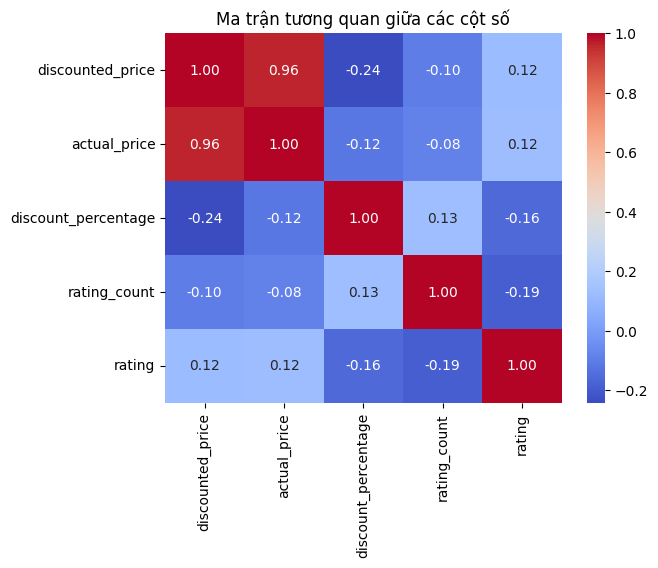

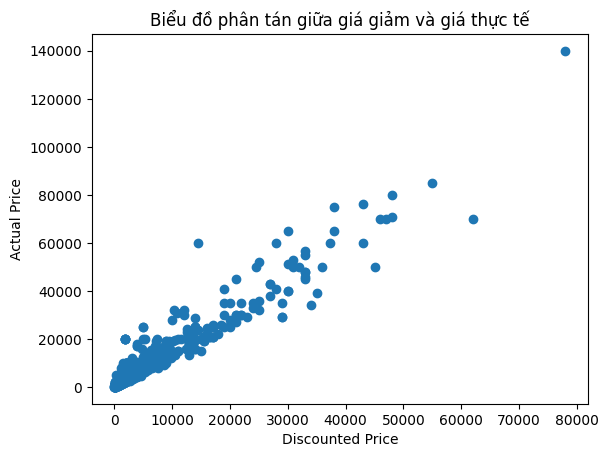

In [ ]:
# Kiểm tra sự tương quan giữa các cột số
correlation_matrix = df[['discounted_price', 'actual_price', 'discount_percentage', 'rating_count', 'rating']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Ma trận tương quan giữa các cột số")
plt.show()
# Vẽ biểu đồ phân tán giữa discounted_price và actual_price
plt.scatter(df['discounted_price'], df['actual_price'])
plt.title("Biểu đồ phân tán giữa giá giảm và giá thực tế")
plt.xlabel("Discounted Price")
plt.ylabel("Actual Price")
plt.show()
